In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 107.6 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zlpg2t7i
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zlpg2t7i
  Resolved https://github.com/openai/CLIP.git to commit d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369393 sha256=4e4df193bb5ac7ec0e3c06b22713c4711eef741ba9090e53e76f3c1c51b9e0d5
  Stored in directory: /tmp/pip-ephem-wheel-cache-2twiuxpa/wheels/ab/4f/3a/5e51521b55

In [2]:
# ! rm -rf pubfig83* && \
# wget http://vision.seas.harvard.edu/pubfig83/pubfig83.v1.tagz && tar xvfz pubfig83.v1.tgz

In [3]:
#import all the needed libs here
import os
import zipfile
import urllib.request
import numpy as np
from PIL import Image, ImageOps
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
import torch
from pkg_resources import packaging
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
# data preprocessing and metrics module in scikit-learn
from sklearn import preprocessing, metrics
# SVM implementation in scikit-learn
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import train_test_split
import clip

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
#Summary of the CLIP model
clip.available_models()
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)
preprocess

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 54.7MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fd7986ecd30>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [5]:
#extracting features from images by using CLIP
def feature_extracting(arr):
  image_input = torch.tensor(np.stack(arr)).cuda()
  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
  image_features /= image_features.norm(dim=-1, keepdim=True)
  image_features = image_features.data.cpu().numpy()
  return image_features

In [6]:
#this function will return the feature vector and the label
def load_data(tag='train'):
  tag_dir = Path.cwd() / tag
  cat = []
  images=[]
  for cat_dir in tag_dir.iterdir():
      cat_label = cat_dir.stem
      # print(cat_label)
      for img_path in os.listdir(cat_dir):
          #print(img_path)
          img = Image.open(os.path.join(cat_dir,img_path)).convert("RGB")
              # img.save(img_path)
          images.append(preprocess(img))
          cat.append(cat_label)
  vec=feature_extracting(images)
  return vec, cat

In [7]:
def cmc(prediction_score,binary_labels):
    test_cmc = []  #保存accuracy，记录rank1到rank48的准确率
    sort_index = np.argsort(-prediction_score,axis=1)#predict_label为模型预测得到的匹配分数矩阵；降序排序，返回匹配分数值从大到小的索引值
    actual_index = np.argmax(binary_labels,1) #test_y为测试样本的真实标签矩阵；返回一列真实标签相对应的最大值的索引值
    predict_index = np.argmax(prediction_score,1)#返回一列预测标签相对应的最大值的索引值
    temp = np.cast['float32'](np.equal(actual_index,predict_index)) #一列相似值，1代表相同，0代表不同, 

    test_cmc.append(np.mean(temp))#rank1
    #rank2 to rank48
    for i in range(sort_index.shape[1]-1):
        for j in range(len(temp)):
            if temp[j]==0:
                predict_index[j] = sort_index[j][i+1]
        temp = np.cast['float32'](np.equal(actual_index,predict_index))
        test_cmc.append(np.mean(temp))
    return test_cmc,sort_index

In [8]:
def roc_and_auc(binary_labels,prediction_score):
    fpr= dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(binary_labels.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], prediction_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr,tpr,roc_auc

In [9]:
def model_fitting(clf,test_set,labels,label_test):
    prediction = clf.predict(test_set)
    # cmat = metrics.confusion_matrix(prediction,label_test)
    # acc = cmat.trace() / cmat.sum()
    acc=clf.score(test_set)
    print('Accuracy: {0:5.2f}%'.format(acc*100))
    return prediction,acc

In [10]:
def model_training(vec_train,label_train):
    clf = LinearSVC(random_state=0, tol=1e-5).fit(vec_train, label_train)
    return clf

In [11]:
def label_binarized(label_test):
    lb=preprocessing.LabelBinarizer()
    binarized_label = lb.fit_transform(label_test)
    return binarized_label

In [12]:
def y_score(clf,vec_train,label_train,vec_test):
    prediction_scores = clf.fit(vec_train, label_train).decision_function(vec_test)
    return prediction_scores

In [36]:
def train_test(vec_train,cat_train):
    X_train, X_test, y_train, y_test = train_test_split(vec_train, cat_train, test_size=0.3, random_state=0)
    le = preprocessing.LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)
    return X_train, X_test, y_train, y_test

Scenario #1 ori vs. low

In [14]:
vec_train_1,cat_train_1=load_data('train')
vec_test_1,cat_test_1 = load_data('low_cloaking')
labels_1 = list(np.unique(np.array(cat_train_1)))
le = preprocessing.LabelEncoder()
label_train_1 = le.fit_transform(cat_train_1)
label_test_1= le.transform(cat_test_1)
clf_1=model_training(vec_train_1,label_train_1)
prediction_1,acc_1=model_fitting(clf_1,vec_test_1,labels_1,label_test_1)
binary_labels_1=label_binarized(label_test_1)
confidence_1=y_score(clf_1,vec_train_1,label_train_1,vec_test_1)
cmc_score,index=cmc(confidence_1,binary_labels_1)
fpr_1,tpr_1,roc_auc_1=roc_and_auc(binary_labels_1,confidence_1) 

Accuracy: 94.01%


Graph for scenario#1

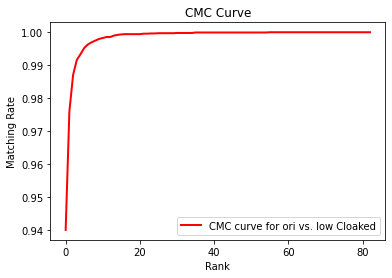

In [16]:
plt.figure()
x1 = np.arange(0,index.shape[1])
plt.plot(x1,cmc_score,color="red",linewidth=2,label="CMC curve for ori vs. low Cloaked")
plt.xlabel("Rank")  
plt.ylabel("Matching Rate") 
plt.title("CMC Curve")
plt.legend(loc="lower right")
plt.show()

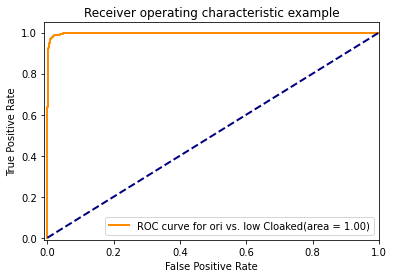

In [21]:
plt.figure()
lw = 2
plt.plot(
    fpr_1[2],
    tpr_1[2],
    color="darkorange",
    lw=lw,
    label="ROC curve for ori vs. low Cloaked(area = %0.2f)" % roc_auc_1[2],
)
plt.plot([0.0, 1], [0.0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

Scenario #2: ori vs. mid

In [19]:
vec_train_2,cat_train_2=load_data('train')
vec_test_2,cat_test_2 = load_data('mid')
labels_2 = list(np.unique(np.array(cat_train_2)))
le = preprocessing.LabelEncoder()
label_train_2 = le.fit_transform(cat_train_2)
label_test_2= le.transform(cat_test_2)
clf_2=model_training(vec_train_2,label_train_2)
prediction_2,acc_2=model_fitting(clf_2,vec_test_2,labels_2,label_test_2)
binary_labels_2=label_binarized(label_test_2)
confidence_2=y_score(clf_2,vec_train_2,label_train_2,vec_test_2)
cmc_score_2,index_2=cmc(confidence_2,binary_labels_2)
fpr_2,tpr_2,roc_auc_2=roc_and_auc(binary_labels_2,confidence_2) 

Accuracy: 85.16%


Graph for scenario#2

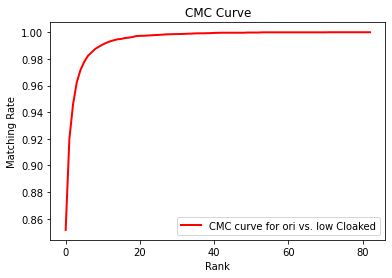

In [20]:
plt.figure()
x2 = np.arange(0,index_2.shape[1])
plt.plot(x2,cmc_score_2,color="red",linewidth=2,label="CMC curve for ori vs. mid Cloaked")
plt.xlabel("Rank")  
plt.ylabel("Matching Rate") 
plt.title("CMC Curve")
plt.legend(loc="lower right")
plt.show()

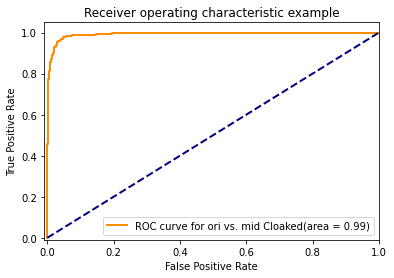

In [22]:
plt.figure()
lw = 2
plt.plot(
    fpr_2[2],
    tpr_2[2],
    color="darkorange",
    lw=lw,
    label="ROC curve for ori vs. mid Cloaked(area = %0.2f)" % roc_auc_2[2],
)
plt.plot([0.0, 1], [0.0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

Scenario#3 : ori vs. high

In [23]:
vec_train_3,cat_train_3=load_data('train')
vec_test_3,cat_test_3 = load_data('High_2')
labels_3 = list(np.unique(np.array(cat_train_3)))
le = preprocessing.LabelEncoder()
label_train_3 = le.fit_transform(cat_train_3)
label_test_3= le.transform(cat_test_3)
clf_3=model_training(vec_train_3,label_train_3)
prediction_3,acc_3=model_fitting(clf_3,vec_test_3,labels_3,label_test_3)
binary_labels_3=label_binarized(label_test_3)
confidence_3=y_score(clf_3,vec_train_3,label_train_3,vec_test_3)
cmc_score_3,index_3=cmc(confidence_3,binary_labels_3)
fpr_3,tpr_3,roc_auc_3=roc_and_auc(binary_labels_3,confidence_3) 

Accuracy: 81.81%


Graphs for Scenario#3

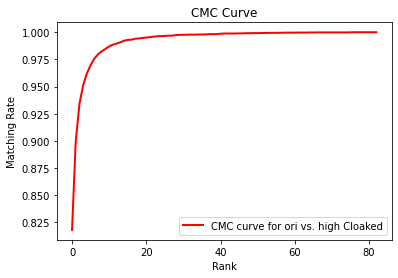

In [24]:
plt.figure()
x3 = np.arange(0,index_3.shape[1])
plt.plot(x3,cmc_score_3,color="red",linewidth=2,label="CMC curve for ori vs. high Cloaked")
plt.xlabel("Rank")  
plt.ylabel("Matching Rate") 
plt.title("CMC Curve")
plt.legend(loc="lower right")
plt.show()

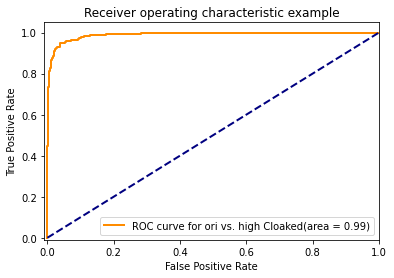

In [25]:
plt.figure()
lw = 2
plt.plot(
    fpr_3[2],
    tpr_3[2],
    color="darkorange",
    lw=lw,
    label="ROC curve for ori vs. high Cloaked(area = %0.2f)" % roc_auc_3[2],
)
plt.plot([0.0, 1], [0.0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

Scenario#4 : ori vs. combined

In [28]:
vec_train_4,cat_train_4=load_data('train')
vec_test_4_1,cat_test_4_1 = load_data('combined_1')
vec_test_4_2,cat_test_4_2 = load_data('combined_2')
vec_test_4_3,cat_test_4_3 = load_data('combined_3')
vec_test_4_4,cat_test_4_4 = load_data('combined_4')
vec_test_4= np.concatenate((vec_test_4_1,vec_test_4_2,vec_test_4_3,vec_test_4_4), axis=0)
cat_test_4 = cat_test_4_1+cat_test_4_2+cat_test_4_3+cat_test_4_4
labels_4 = list(np.unique(np.array(cat_train_4)))
le = preprocessing.LabelEncoder()
label_train_4 = le.fit_transform(cat_train_4)
label_test_4= le.transform(cat_test_4)
clf_4=model_training(vec_train_4,label_train_4)
prediction_4,acc_4=model_fitting(clf_4,vec_test_4,labels_4,label_test_4)
binary_labels_4=label_binarized(label_test_4)
confidence_4=y_score(clf_4,vec_train_4,label_train_4,vec_test_4)
cmc_score_4,index_4=cmc(confidence_4,binary_labels_4)
fpr_4,tpr_4,roc_auc_4=roc_and_auc(binary_labels_4,confidence_4) 

Accuracy: 87.82%


Graphs for Scenario#4

plt.figure()
x4 = np.arange(0,index_4.shape[1])
plt.plot(x4,cmc_score_4,color="red",linewidth=2,label="CMC curve for ori vs. combined")
plt.xlabel("Rank")  
plt.ylabel("Matching Rate") 
plt.title("CMC Curve")
plt.legend(loc="lower right")
plt.show()

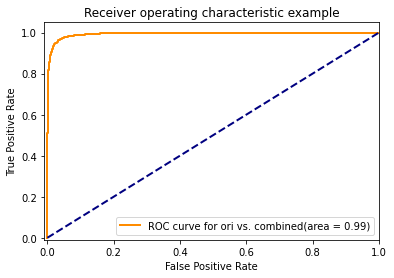

In [30]:
plt.figure()
lw = 2
plt.plot(
    fpr_4[2],
    tpr_4[2],
    color="darkorange",
    lw=lw,
    label="ROC curve for ori vs. combined(area = %0.2f)" % roc_auc_4[2],
)
plt.plot([0.0, 1], [0.0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

Graphs for the four scenarios:

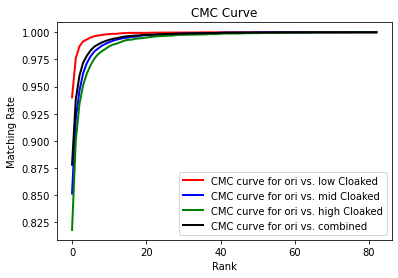

In [33]:
plt.figure()
# x4 = np.arange(0,index_4.shape[1])
# x3 = np.arange(0,index_3.shape[1])
plt.plot(x1,cmc_score,color="red",linewidth=2,label="CMC curve for ori vs. low Cloaked")
plt.plot(x2,cmc_score_2,color="blue",linewidth=2,label="CMC curve for ori vs. mid Cloaked")
plt.plot(x3,cmc_score_3,color="green",linewidth=2,label="CMC curve for ori vs. high Cloaked")
plt.plot(x4,cmc_score_4,color="black",linewidth=2,label="CMC curve for ori vs. combined")
plt.xlabel("Rank")  
plt.ylabel("Matching Rate") 
plt.title("CMC Curve")
plt.legend(loc="lower right")
plt.show()

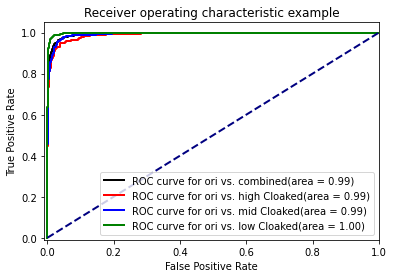

In [34]:
plt.figure()
lw = 2
plt.plot(
    fpr_4[2],
    tpr_4[2],
    color="black",
    lw=lw,
    label="ROC curve for ori vs. combined(area = %0.2f)" % roc_auc_4[2],
)
lw = 2
plt.plot(
    fpr_3[2],
    tpr_3[2],
    color="red",
    lw=lw,
    label="ROC curve for ori vs. high Cloaked(area = %0.2f)" % roc_auc_3[2],
)
lw = 2
plt.plot(
    fpr_2[2],
    tpr_2[2],
    color="blue",
    lw=lw,
    label="ROC curve for ori vs. mid Cloaked(area = %0.2f)" % roc_auc_2[2],
)
lw = 2
plt.plot(
    fpr_1[2],
    tpr_1[2],
    color="green",
    lw=lw,
    label="ROC curve for ori vs. low Cloaked(area = %0.2f)" % roc_auc_1[2],
)
plt.plot([0.0, 1], [0.0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

Scenario#5_1 : mixture of ori and low

In [37]:
vec_train_low_1,cat_train_low_1=load_data('ori_low1')
vec_train_low_2,cat_train_low_2=load_data('ori_low2')
vec_train_low = np.concatenate((vec_train_low_1,vec_train_low_2),axis=0)
cat_train_low = cat_train_low_1+cat_train_low_2
X_train_low, X_test_low, y_train_low, y_test_low=train_test(vec_train_low,cat_train_low)
labels_low = list(np.unique(np.array(cat_train_low)))
clf_low=model_training(X_train_low,y_train_low)
prediction_low,acc_low=model_fitting(clf_low,X_test_low,labels_low,y_test_low)
binary_labels_low=label_binarized(y_test_low)
confidence_low=y_score(clf_low,X_train_low,y_train_low,X_test_low)
cmc_score_low,index_low=cmc(confidence_low,binary_labels_low)
fpr_low,tpr_low,roc_auc_low=roc_and_auc(binary_labels_low,confidence_low) 

Accuracy: 95.21%


graphs for scenario#5_1

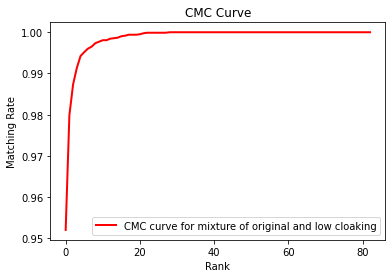

In [57]:
plt.figure()
x_low = np.arange(0,index_low.shape[1])
plt.plot(x_low,cmc_score_low,color="red",linewidth=2,label="CMC curve for mixture of original and low cloaking")
plt.xlabel("Rank")  
plt.ylabel("Matching Rate") 
plt.title("CMC Curve")
plt.legend(loc="lower right")
plt.show()

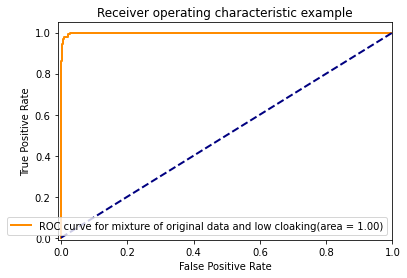

In [39]:
plt.figure()
lw = 2
plt.plot(
    fpr_low[2],
    tpr_low[2],
    color="darkorange",
    lw=lw,
    label="ROC curve for mixture of original data and low cloaking(area = %0.2f)" % roc_auc_low[2],
)
plt.plot([0.0, 1], [0.0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

Scenario#5_2: mixture of orignial images and mid cloaking images

In [41]:
vec_train_mid_1,cat_train_mid_1=load_data('mid_cloaking1')
vec_train_mid_2,cat_train_mid_2=load_data('mid_cloaking2')
vec_train_mid = np.concatenate((vec_train_mid_1,vec_train_mid_2),axis=0)
cat_train_mid = cat_train_mid_1+cat_train_mid_2
X_train_mid, X_test_mid, y_train_mid, y_test_mid=train_test(vec_train_mid,cat_train_mid)
labels_mid = list(np.unique(np.array(cat_train_mid)))
clf_mid=model_training(X_train_mid,y_train_mid)
prediction_mid,acc_mid=model_fitting(clf_mid,X_test_mid,labels_mid,y_test_mid)
binary_labels_mid=label_binarized(y_test_mid)
confidence_mid=y_score(clf_mid,X_train_mid,y_train_mid,X_test_mid)
cmc_score_mid,index_mid=cmc(confidence_mid,binary_labels_mid)
fpr_mid,tpr_mid,roc_auc_mid=roc_and_auc(binary_labels_mid,confidence_mid) 

Accuracy: 92.38%


Graphs for Scenario#5_2

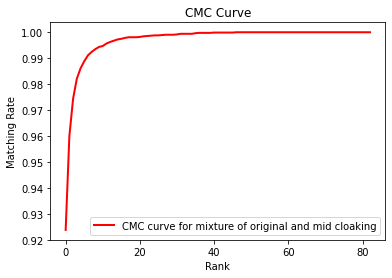

In [56]:
plt.figure()
x_mid = np.arange(0,index_mid.shape[1])
plt.plot(x_mid,cmc_score_mid,color="red",linewidth=2,label="CMC curve for mixture of original and mid cloaking")
plt.xlabel("Rank")  
plt.ylabel("Matching Rate") 
plt.title("CMC Curve")
plt.legend(loc="lower right")
plt.show()

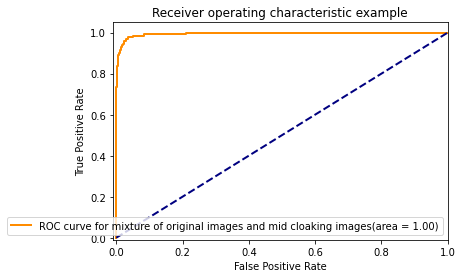

In [43]:
plt.figure()
lw = 2
plt.plot(
    fpr_mid[2],
    tpr_mid[2],
    color="darkorange",
    lw=lw,
    label="ROC curve for mixture of original images and mid cloaking images(area = %0.2f)" % roc_auc_mid[2],
)
plt.plot([0.0, 1], [0.0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

Scenario#5_3: mixture of orignial images and high cloaking images

In [44]:
vec_train_high_1,cat_train_high_1=load_data('ori_high1')
vec_train_high_2,cat_train_high_2=load_data('ori_high2')
vec_train_high = np.concatenate((vec_train_high_1,vec_train_high_2),axis=0)
cat_train_high = cat_train_high_1+cat_train_high_2
X_train_high, X_test_high, y_train_high, y_test_high=train_test(vec_train_high,cat_train_high)
labels_high = list(np.unique(np.array(cat_train_high)))
clf_high=model_training(X_train_high,y_train_high)
prediction_high,acc_high=model_fitting(clf_high,X_test_high,labels_high,y_test_high)
binary_labels_high=label_binarized(y_test_high)
confidence_high=y_score(clf_high,X_train_high,y_train_high,X_test_high)
cmc_score_high,index_high=cmc(confidence_high,binary_labels_high)
fpr_high,tpr_high,roc_auc_high=roc_and_auc(binary_labels_high,confidence_high) 

Accuracy: 91.94%


Graphs for Scenario#5_3

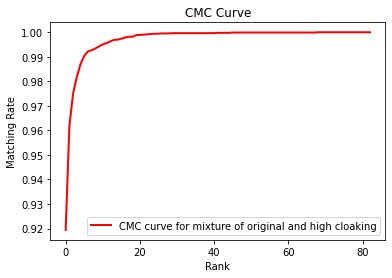

In [55]:
plt.figure()
x_high = np.arange(0,index_high.shape[1])
plt.plot(x_high,cmc_score_high,color="red",linewidth=2,label="CMC curve for mixture of original and high cloaking")
plt.xlabel("Rank")  
plt.ylabel("Matching Rate") 
plt.title("CMC Curve")
plt.legend(loc="lower right")
plt.show()

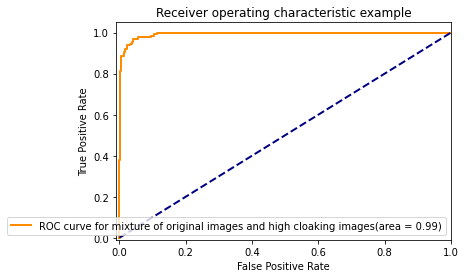

In [54]:
plt.figure()
lw = 2
plt.plot(
    fpr_high[2],
    tpr_high[2],
    color="darkorange",
    lw=lw,
    label="ROC curve for mixture of original images and high cloaking images(area = %0.2f)" % roc_auc_high[2],
)
plt.plot([0.0, 1], [0.0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

Scenario#5_4: mixture of orignial images and all cloaked images

In [47]:
vec_train_c_1,cat_train_c_1=load_data('c1')
vec_train_c_2,cat_train_c_2=load_data('c2')
vec_train_c_3,cat_train_c_3=load_data('c3')
vec_train_c_4,cat_train_c_4=load_data('c4')
vec_train_c = np.concatenate((vec_train_c_1,vec_train_c_2,vec_train_c_3,vec_train_c_4),axis=0)
cat_train_c = cat_train_c_1+cat_train_c_2+cat_train_c_3+cat_train_c_4
X_train_c, X_test_c, y_train_c, y_test_c=train_test(vec_train_c,cat_train_c)
labels_c = list(np.unique(np.array(cat_train_c)))
clf_c=model_training(X_train_c,y_train_c)
prediction_c,acc_c=model_fitting(clf_c,X_test_c,labels_c,y_test_c)
binary_labels_c=label_binarized(y_test_c)
confidence_c=y_score(clf_c,X_train_c,y_train_c,X_test_c)
cmc_score_c,index_c=cmc(confidence_c,binary_labels_c)
fpr_c,tpr_c,roc_auc_c=roc_and_auc(binary_labels_c,confidence_c) 

Accuracy: 94.48%


Graphs for Scenario#5_4

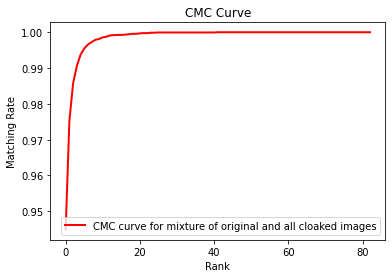

In [58]:
plt.figure()
x_c = np.arange(0,index_c.shape[1])
plt.plot(x_c,cmc_score_c,color="red",linewidth=2,label="CMC curve for mixture of original and all cloaked images")
plt.xlabel("Rank")  
plt.ylabel("Matching Rate") 
plt.title("CMC Curve")
plt.legend(loc="lower right")
plt.show()

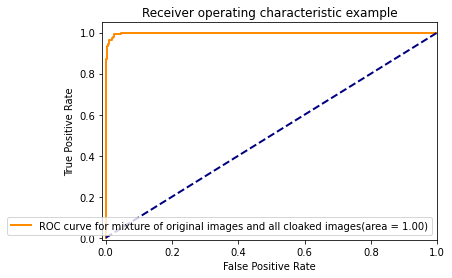

In [49]:
plt.figure()
lw = 2
plt.plot(
    fpr_c[2],
    tpr_c[2],
    color="darkorange",
    lw=lw,
    label="ROC curve for mixture of original images and all cloaked images(area = %0.2f)" % roc_auc_c[2],
)
plt.plot([0.0, 1], [0.0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

Overall Graphs for Scenario#5

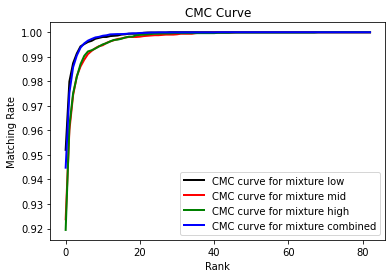

In [59]:
plt.figure()
plt.plot(x_low,cmc_score_low,color="black",linewidth=2,label="CMC curve for mixture low")
plt.plot(x_mid,cmc_score_mid,color="red",linewidth=2,label="CMC curve for mixture mid")
plt.plot(x_high,cmc_score_high,color="green",linewidth=2,label="CMC curve for mixture high")
plt.plot(x_c,cmc_score_c,color="blue",linewidth=2,label="CMC curve for mixture combined")
plt.xlabel("Rank")  
plt.ylabel("Matching Rate") 
plt.title("CMC Curve")
plt.legend(loc="lower right")
plt.show()

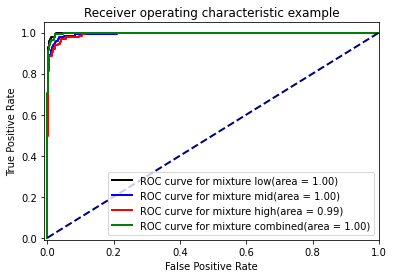

In [61]:
plt.figure()
lw = 2
plt.plot(
    fpr_low[2],
    tpr_low[2],
    color="black",
    lw=lw,
    label="ROC curve for mixture low(area = %0.2f)" % roc_auc_low[2],
)
lw = 2
plt.plot(
    fpr_mid[2],
    tpr_mid[2],
    color="blue",
    lw=lw,
    label="ROC curve for mixture mid(area = %0.2f)" % roc_auc_mid[2],
)
lw = 2
plt.plot(
    fpr_high[2],
    tpr_high[2],
    color="red",
    lw=lw,
    label="ROC curve for mixture high(area = %0.2f)" % roc_auc_high[2],
)
lw = 2
plt.plot(
    fpr_c[2],
    tpr_c[2],
    color="green",
    lw=lw,
    label="ROC curve for mixture combined(area = %0.2f)" % roc_auc_c[2],
)
plt.plot([0.0, 1], [0.0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()